In [ ]:
# pip install lightgbm catboost xgboost

import sys
!pip install lightgbm catboost xgboost
# -------------------------------------------------
# 0. Imports & Setup
# -------------------------------------------------
import pandas as pd
import numpy as np
import gc
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import catboost as cb
import xgboost as xgb


In [4]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
# -------------------------------------------------
# 1. Load Data
# -------------------------------------------------
DATA_PATH = "D:/CODE_SPACE/demand-forecasting-kernels-only/"

train = pd.read_csv(DATA_PATH + 'train.csv')
test  = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

# CRITICAL: Convert 'date' to datetime
train['date'] = pd.to_datetime(train['date'])
test['date']  = pd.to_datetime(test['date'])

print(f"Train shape: {train.shape}")
print(f"Test  shape: {test.shape}")
print("Train dtypes:\n", train.dtypes)
# -------------------------------------------------
# 2. Comprehensive Data Exploration & Visualization
# -------------------------------------------------
print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Basic statistics
print("\nSales Statistics:")
print(train['sales'].describe())

# Check for missing values
print(f"\nMissing values in train: {train.isnull().sum().sum()}")
print(f"Missing values in test: {test.isnull().sum().sum()}")

# Create store_item identifier
train['store_item'] = train['store'].astype(str) + '_' + train['item'].astype(str)
test['store_item']  = test['store'].astype(str)  + '_' + test['item'].astype(str)

# Sort data
train = train.sort_values(['store_item', 'date']).reset_index(drop=True)
test  = test.sort_values(['store_item', 'date']).reset_index(drop=True)

Train shape: (913000, 4)
Test  shape: (45000, 4)
Train dtypes:
 date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

DATA EXPLORATION

Sales Statistics:
count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

Missing values in train: 0
Missing values in test: 0



DATA VISUALIZATION


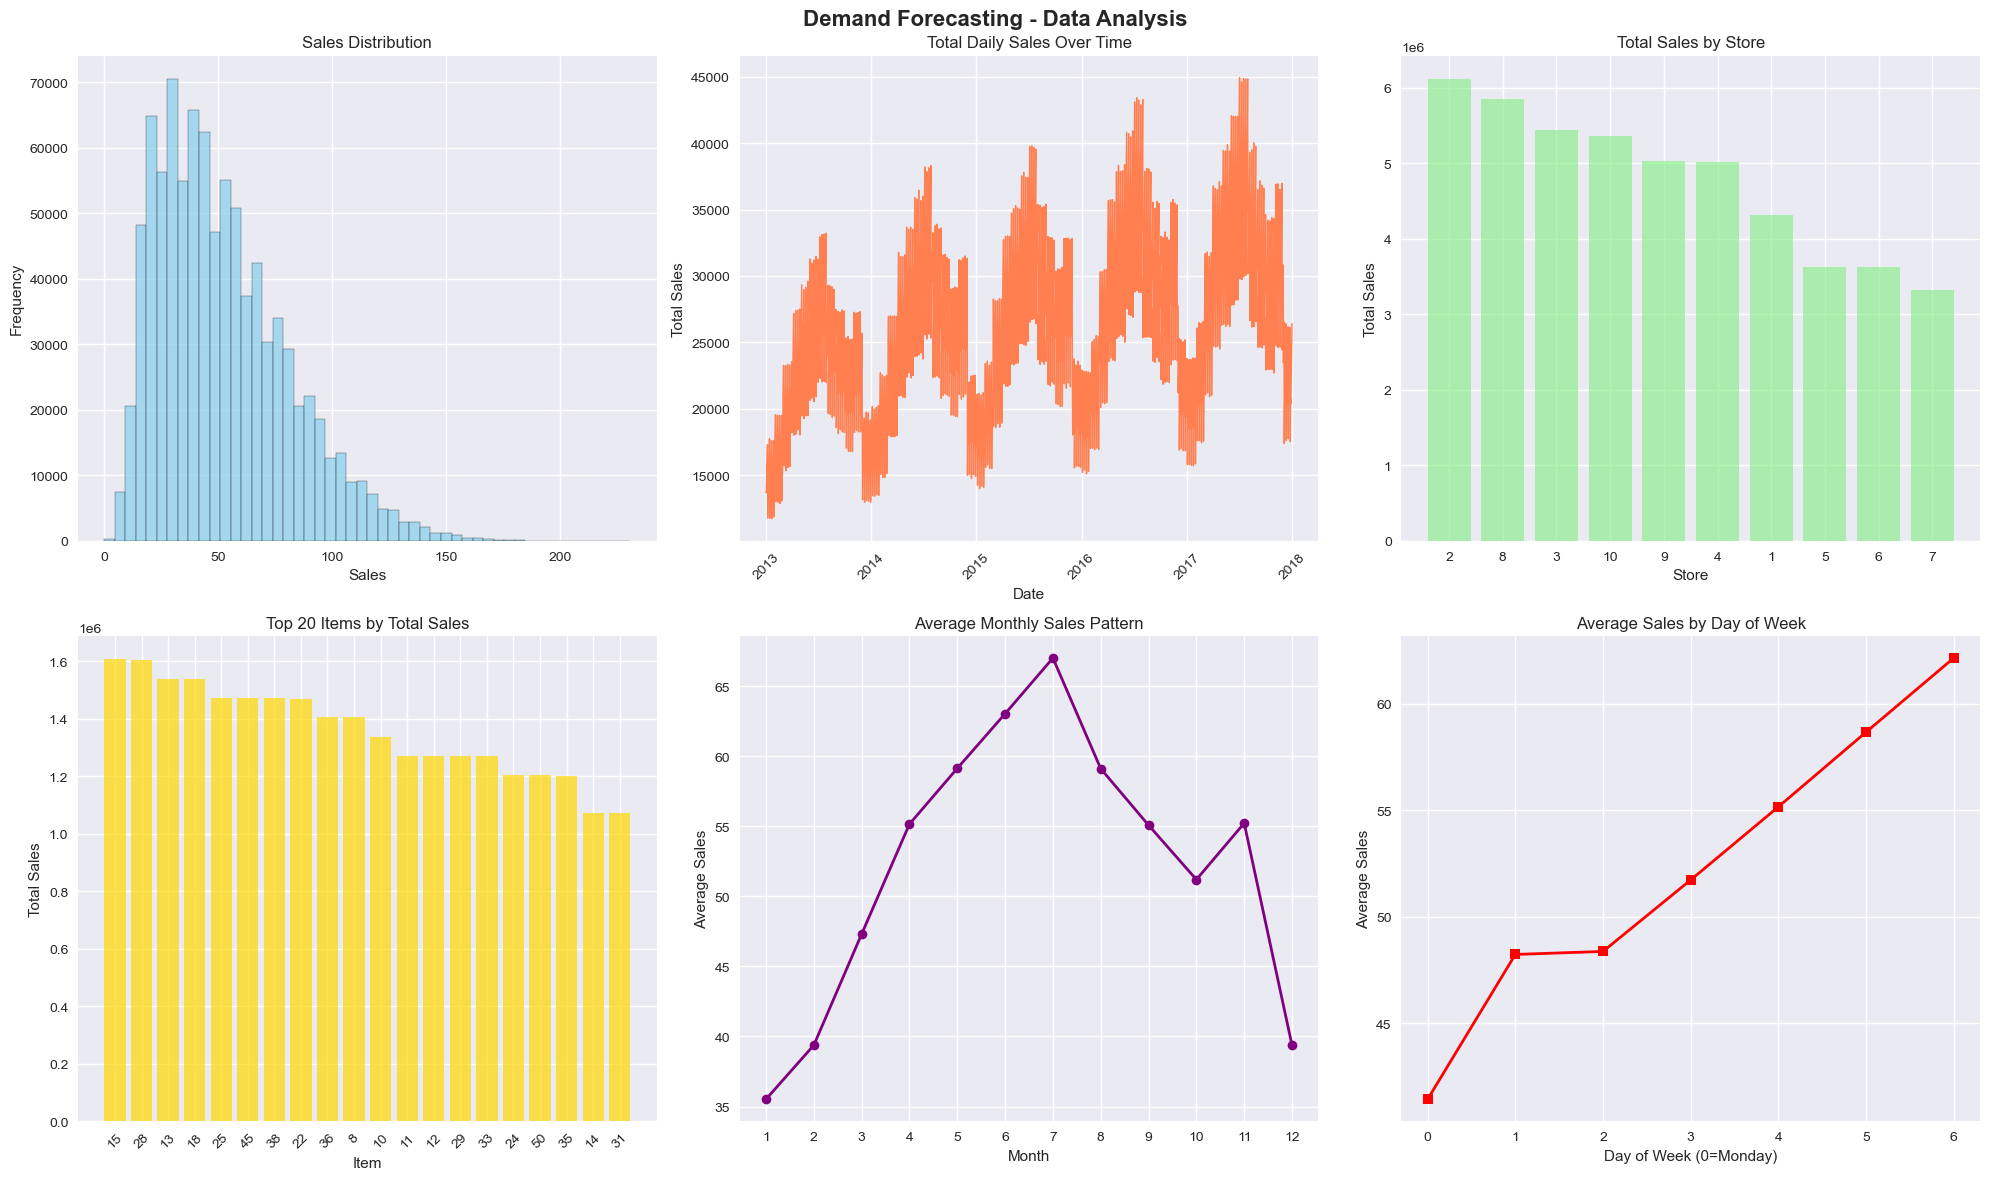

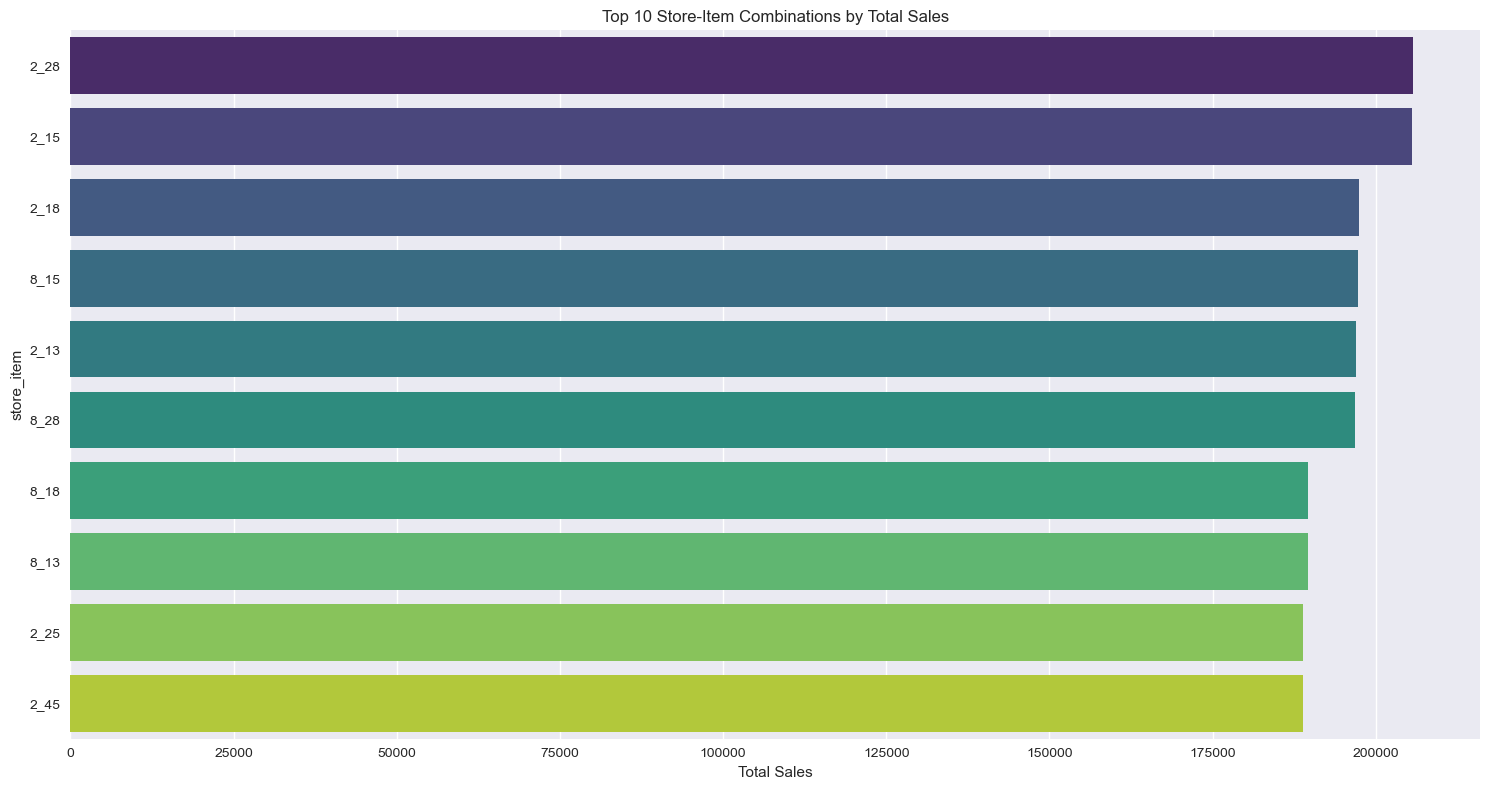

In [5]:
# -------------------------------------------------
# 2.1 Comprehensive Visualization
# -------------------------------------------------
print("\n" + "="*50)
print("DATA VISUALIZATION")
print("="*50)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Demand Forecasting - Data Analysis', fontsize=16, fontweight='bold')

# 1. Sales distribution
axes[0,0].hist(train['sales'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Sales Distribution')
axes[0,0].set_xlabel('Sales')
axes[0,0].set_ylabel('Frequency')

# 2. Sales over time (aggregated)
daily_sales = train.groupby('date')['sales'].sum()
axes[0,1].plot(daily_sales.index, daily_sales.values, color='coral', linewidth=1)
axes[0,1].set_title('Total Daily Sales Over Time')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Total Sales')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Sales by store
store_sales = train.groupby('store')['sales'].sum().sort_values(ascending=False)
axes[0,2].bar(store_sales.index.astype(str), store_sales.values, color='lightgreen', alpha=0.7)
axes[0,2].set_title('Total Sales by Store')
axes[0,2].set_xlabel('Store')
axes[0,2].set_ylabel('Total Sales')

# 4. Sales by item
item_sales = train.groupby('item')['sales'].sum().sort_values(ascending=False).head(20)
axes[1,0].bar(item_sales.index.astype(str), item_sales.values, color='gold', alpha=0.7)
axes[1,0].set_title('Top 20 Items by Total Sales')
axes[1,0].set_xlabel('Item')
axes[1,0].set_ylabel('Total Sales')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Monthly sales pattern
train['month'] = train['date'].dt.month
monthly_sales = train.groupby('month')['sales'].mean()
axes[1,1].plot(monthly_sales.index, monthly_sales.values, marker='o', color='purple', linewidth=2)
axes[1,1].set_title('Average Monthly Sales Pattern')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Average Sales')
axes[1,1].set_xticks(range(1, 13))

# 6. Weekly pattern
train['dayofweek'] = train['date'].dt.dayofweek
weekly_sales = train.groupby('dayofweek')['sales'].mean()
axes[1,2].plot(weekly_sales.index, weekly_sales.values, marker='s', color='red', linewidth=2)
axes[1,2].set_title('Average Sales by Day of Week')
axes[1,2].set_xlabel('Day of Week (0=Monday)')
axes[1,2].set_ylabel('Average Sales')
axes[1,2].set_xticks(range(0, 7))

plt.tight_layout()
plt.show()

# Additional visualization: Top store-item combinations
plt.figure(figsize=(15, 8))
top_combinations = train.groupby('store_item')['sales'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_combinations.values, y=top_combinations.index, palette='viridis')
plt.title('Top 10 Store-Item Combinations by Total Sales')
plt.xlabel('Total Sales')
plt.tight_layout()
plt.show()



CLASS IMBALANCE ANALYSIS
Sales Descriptive Statistics:
count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

Sales Quantile Analysis:
   0%:    0.0
  25%:   30.0
  50%:   47.0
  75%:   70.0
  90%:   93.0
  95%:  107.0
  99%:  135.0
  100%:  231.0


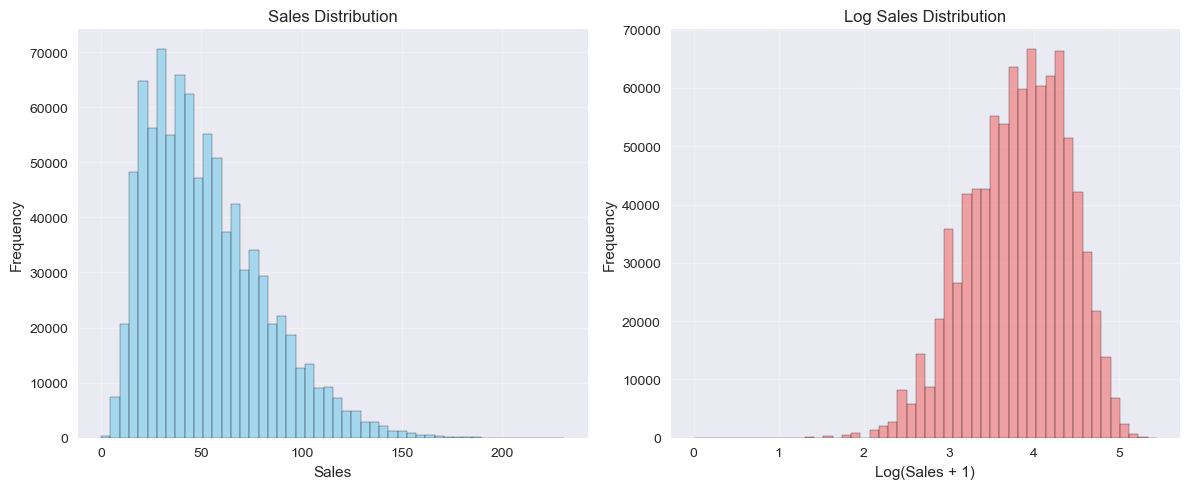


Imbalance Metrics:
  Skewness: 0.8671 (Moderately skewed)
  Kurtosis: 0.5091 (Light-tailed)

Extreme Values:
  High sales (>2x median): 84483 (9.25%)
  Low sales (<0.5x median): 141304 (15.48%)


In [6]:
# -------------------------------------------------
# 2.2 Class Imbalance Analysis - SIMPLIFIED APPROACH
# -------------------------------------------------
print("\n" + "="*50)
print("CLASS IMBALANCE ANALYSIS")
print("="*50)

# Simple approach without categorical binning
print("Sales Descriptive Statistics:")
print(train['sales'].describe())

# Analyze sales distribution using quantiles
quantile_ranges = [0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
quantile_values = train['sales'].quantile(quantile_ranges)

print("\nSales Quantile Analysis:")
for q, val in zip(quantile_ranges, quantile_values):
    print(f"  {q*100:2.0f}%: {val:6.1f}")

# Create a simple histogram for visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train['sales'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Log scale to better see the distribution
plt.hist(np.log1p(train['sales']), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Log Sales Distribution')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate imbalance metrics
sales_skew = train['sales'].skew()
sales_kurtosis = train['sales'].kurtosis()

print(f"\nImbalance Metrics:")
print(f"  Skewness: {sales_skew:.4f} ({'Highly skewed' if abs(sales_skew) > 1 else 'Moderately skewed'})")
print(f"  Kurtosis: {sales_kurtosis:.4f} ({'Heavy-tailed' if sales_kurtosis > 3 else 'Light-tailed'})")

# Count high vs low sales
median_sales = train['sales'].median()
high_sales_count = (train['sales'] > median_sales * 2).sum()
low_sales_count = (train['sales'] < median_sales * 0.5).sum()

print(f"\nExtreme Values:")
print(f"  High sales (>2x median): {high_sales_count} ({high_sales_count/len(train)*100:.2f}%)")
print(f"  Low sales (<0.5x median): {low_sales_count} ({low_sales_count/len(train)*100:.2f}%)")

In [7]:
# -------------------------------------------------
# 3. Enhanced Feature Engineering - 
# -------------------------------------------------
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

def create_features(train_df, test_df=None):
    """
    Creates features using only historical sales from train.
    Works for both train and test.
    """
    # Determine if we're processing train or test
    is_train = test_df is None
    df = train_df.copy() if is_train else test_df.copy()

    # CRITICAL: CREATE store_item HERE
    df['store_item'] = df['store'].astype(str) + '_' + df['item'].astype(str)

    # Date features
    df['year']       = df['date'].dt.year
    df['month']      = df['date'].dt.month
    df['week']       = df['date'].dt.isocalendar().week.astype(int)
    df['day']        = df['date'].dt.day
    df['dayofweek']  = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['dayofyear']  = df['date'].dt.dayofyear
    df['quarter']    = df['date'].dt.quarter
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end']   = df['date'].dt.is_month_end.astype(int)

    # Use train sales as historical series
    hist_sales = train_df.set_index(['store_item', 'date'])['sales']

    # Build features
    features = df[['store_item', 'date']].copy()

    # Lags
    lags = [1, 2, 3, 7, 14, 28, 90]
    for lag in lags:
        features[f'lag_{lag}'] = features.set_index(['store_item', 'date']).index.map(
            hist_sales.shift(lag)
        )

    # Rolling stats
    windows = [7, 14, 28, 60]
    for w in windows:
        roll_mean = hist_sales.groupby('store_item').shift(1).rolling(w, min_periods=1).mean()
        roll_std  = hist_sales.groupby('store_item').shift(1).rolling(w, min_periods=1).std()
        roll_min  = hist_sales.groupby('store_item').shift(1).rolling(w, min_periods=1).min()
        roll_max  = hist_sales.groupby('store_item').shift(1).rolling(w, min_periods=1).max()
        
        features[f'roll_mean_{w}'] = features.set_index(['store_item', 'date']).index.map(roll_mean)
        features[f'roll_std_{w}']  = features.set_index(['store_item', 'date']).index.map(roll_std)
        features[f'roll_min_{w}']  = features.set_index(['store_item', 'date']).index.map(roll_min)
        features[f'roll_max_{w}']  = features.set_index(['store_item', 'date']).index.map(roll_max)

    # Expanding stats
    exp_mean = hist_sales.groupby('store_item').shift(1).expanding().mean()
    exp_std = hist_sales.groupby('store_item').shift(1).expanding().std()
    features['exp_mean'] = features.set_index(['store_item', 'date']).index.map(exp_mean)
    features['exp_std'] = features.set_index(['store_item', 'date']).index.map(exp_std)

    # Seasonal features (yearly pattern)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['sin_day'] = np.sin(2 * np.pi * df['day'] / 31)
    df['cos_day'] = np.cos(2 * np.pi * df['day'] / 31)

    # Merge features back
    df = df.merge(features.drop(columns=['store_item', 'date']), 
                  left_index=True, right_index=True, how='left')

    # Fill NaN
    lag_cols = [c for c in df.columns if c.startswith(('lag_', 'roll_', 'exp_'))]
    df[lag_cols] = df[lag_cols].fillna(0)

    # Categorical encoding - ONLY for store, item, store_item
    df['store'] = df['store'].astype('category')
    df['item']  = df['item'].astype('category')
    df['store_item'] = df['store_item'].astype('category')

    return df

# Apply feature engineering
print("Creating features...")
train_feat = create_features(train)
test_feat  = create_features(train, test)

print(f"Train features shape: {train_feat.shape}")
print(f"Test features shape: {test_feat.shape}")


FEATURE ENGINEERING
Creating features...
Train features shape: (913000, 44)
Test features shape: (45000, 44)


In [8]:

# -------------------------------------------------
# 4. Handle Class Imbalance - 
# -------------------------------------------------
print("\n" + "="*50)
print("HANDLING CLASS IMBALANCE")
print("="*50)

# Create sample weights - give more weight to rare high-sales events
train_feat['sample_weight'] = 1.0
high_sales_threshold = train_feat['sales'].quantile(0.9)
high_sales_mask = train_feat['sales'] > high_sales_threshold
train_feat.loc[high_sales_mask, 'sample_weight'] = 2.0

print(f"High sales events (>90th percentile {high_sales_threshold:.2f}): {high_sales_mask.sum()}")


HANDLING CLASS IMBALANCE
High sales events (>90th percentile 93.00): 88274


In [9]:

# -------------------------------------------------
# 5. Train/Val Split - 
# -------------------------------------------------
max_date = train['date'].max()
val_start = max_date - pd.Timedelta(days=90)  # Longer validation for time series

train_set = train_feat[train_feat['date'] < val_start].copy()
valid_set = train_feat[train_feat['date'] >= val_start].copy()

# Remove any categorical columns that might cause issues (except the ones we explicitly want)
columns_to_drop = ['date', 'sales', 'sample_weight']
X_train = train_set.drop(columns=columns_to_drop)
y_train = train_set['sales']
sample_weights = train_set['sample_weight']

X_valid = valid_set.drop(columns=columns_to_drop)
y_valid = valid_set['sales']

X_test = test_feat.drop(columns=['date'])

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_valid.shape}")
print(f"Test set: {X_test.shape}")

# Check categorical columns
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()
print(f"Categorical columns: {categorical_columns}")


Training set: (867500, 42)
Validation set: (45500, 42)
Test set: (45000, 43)
Categorical columns: ['store', 'item', 'store_item']


In [10]:

# -------------------------------------------------
# 6. Enhanced RMSSE Function
# -------------------------------------------------
def rmsse(y_true, y_pred, y_hist):
    """Root Mean Squared Scaled Error"""
    if len(y_hist) < 2:
        return np.nan
    scale = np.mean(np.diff(y_hist)**2)
    if scale == 0:
        return np.nan
    return np.sqrt(np.mean((y_true - y_pred)**2) / scale)

def compute_rmsse(val_df, pred):
    """Compute RMSSE for each store-item combination"""
    scores = []
    for sid in val_df['store_item'].unique():
        mask = val_df['store_item'] == sid
        if mask.sum() == 0:
            continue
        y_t = val_df[mask]['sales'].values
        y_p = pred[mask]
        
        # Get historical data for scaling
        historical_mask = train_set['store_item'] == sid
        if historical_mask.sum() > 1:  # Need at least 2 points for differencing
            y_h = train_set[historical_mask]['sales'].values
            score = rmsse(y_t, y_p, y_h)
            if not np.isnan(score):
                scores.append(score)
    
    return np.mean(scores) if scores else np.nan

def evaluate_model(model_name, y_true, y_pred, val_df):
    """Comprehensive model evaluation"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    rmsse_score = compute_rmsse(val_df, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"  RMSE:  {rmse:.4f}")
    print(f"  MAE:   {mae:.4f}")
    print(f"  RMSSE: {rmsse_score:.4f}")
    print("-" * 40)
    
    return {'RMSE': rmse, 'MAE': mae, 'RMSSE': rmsse_score}


In [11]:
# -------------------------------------------------
# 7. Multiple Model Training & Comparison - FIXED
# -------------------------------------------------
print("\n" + "="*50)
print("MODEL TRAINING & COMPARISON")
print("="*50)

results = {}
cat_features = ['store', 'item', 'store_item']  # Only these categorical features

# 7.1 LightGBM
print("Training LightGBM...")
lgb_train = lgb.Dataset(X_train, label=y_train, weight=sample_weights,
                       categorical_feature=cat_features, free_raw_data=False)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train,
                       categorical_feature=cat_features, free_raw_data=False)

lgb_params = {
    'objective': 'poisson',  # Good for count data
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 128,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'seed': 42
}

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_valid],
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(200)
    ]
)

lgb_pred = lgb_model.predict(X_valid)
results['LightGBM'] = evaluate_model("LightGBM", y_valid, lgb_pred, valid_set)

# 7.2 CatBoost
print("Training CatBoost...")

# Ensure we only have the intended categorical features
cb_train_pool = cb.Pool(X_train, y_train, cat_features=cat_features, weight=sample_weights)
cb_valid_pool = cb.Pool(X_valid, y_valid, cat_features=cat_features)

cb_model = cb.CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

cb_model.fit(
    cb_train_pool,
    eval_set=cb_valid_pool,
    verbose=50,
    plot=False
)

cb_pred = cb_model.predict(X_valid)
results['CatBoost'] = evaluate_model("CatBoost", y_valid, cb_pred, valid_set)

# 7.3 XGBoost - FIXED
print("Training XGBoost...")
# Encode categorical variables for XGBoost
encoder = LabelEncoder()
X_train_encoded = X_train.copy()
X_valid_encoded = X_valid.copy()

for col in cat_features:
    X_train_encoded[col] = encoder.fit_transform(X_train[col])
    X_valid_encoded[col] = encoder.transform(X_valid[col])

# XGBoost: early_stopping_rounds goes in the constructor, not fit()
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,  # Increased for early stopping
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=50  # MOVED HERE from fit() method
)

xgb_model.fit(
    X_train_encoded, 
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_valid_encoded, y_valid)],
    verbose=100
)

xgb_pred = xgb_model.predict(X_valid_encoded)
results['XGBoost'] = evaluate_model("XGBoost", y_valid, xgb_pred, valid_set)

# 7.4 Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

# Use encoded features for RF
rf_model.fit(X_train_encoded, y_train)
rf_pred = rf_model.predict(X_valid_encoded)
results['Random Forest'] = evaluate_model("Random Forest", y_valid, rf_pred, valid_set)

# 7.5 Gradient Boosting (Optional)
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

gb_model.fit(X_train_encoded, y_train)
gb_pred = gb_model.predict(X_valid_encoded)
results['Gradient Boosting'] = evaluate_model("Gradient Boosting", y_valid, gb_pred, valid_set)


MODEL TRAINING & COMPARISON
Training LightGBM...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6160
[LightGBM] [Info] Number of data points in the train set: 867500, number of used features: 42
[LightGBM] [Info] Start training from score 4.050440
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 7.82147
[400]	valid_0's rmse: 7.72542
[600]	valid_0's rmse: 7.68828
[800]	valid_0's rmse: 7.67082
[1000]	valid_0's rmse: 7.65918
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 7.65896
LightGBM Performance:
  RMSE:  7.6590
  MAE:   5.9095
  RMSSE: 0.5678
----------------